## Linking yt-napari Layers

When you load layers, napari treats them independently. This means that when you load different subsections of a yt domain, the colormap scaling will be independent for each layer even if they are the same field. Napari allows you to link layers so that when the attributes of one layer they are applied across all linked layers and `yt_napari` some helper functions to streamline the process for adjusting colormap limits. 

First let's load up some sections of the same domain:

In [1]:
import napari
import yt

In [2]:
viewer = napari.Viewer()

In [3]:
ds = yt.load("IsolatedGalaxy/galaxy0030/galaxy0030")

yt : [INFO     ] 2024-08-28 09:42:25,943 Parameters: current_time              = 0.0060000200028298
yt : [INFO     ] 2024-08-28 09:42:25,943 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2024-08-28 09:42:25,944 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-08-28 09:42:25,944 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-08-28 09:42:25,944 Parameters: cosmological_simulation   = 0


In [4]:
from yt_napari.viewer import Scene
yt_scene = Scene()

In [5]:
left_edge = ds.domain_center - ds.arr([10, 10, 10], 'kpc')
right_edge = ds.domain_center + ds.arr([10, 10, 10], 'kpc')
yt_scene.add_region(viewer,
                    ds,
                    ("enzo", "Density"),
                    left_edge = left_edge,
                    right_edge = right_edge,                       
                    resolution=(600, 600, 600),
                    colormap="magma",
                    name="Density_1",
                    blending="translucent")

left_edge = ds.domain_center + ds.arr([10, 10, 10], 'kpc')
right_edge = left_edge + ds.arr([20, 20, 20], 'kpc')
yt_scene.add_region(viewer,
                    ds,
                    ("enzo", "Density"),
                    left_edge = left_edge,
                    right_edge = right_edge,                       
                    resolution=(300, 300, 300),
                    colormap="magma",
                    name="Density_2",
                    blending="translucent")

left_edge = ds.domain_center + ds.arr([-10, -10, 10], 'kpc')
right_edge = left_edge + ds.arr([20, 20, 20], 'kpc')
yt_scene.add_region(viewer,
                    ds,
                    ("enzo", "Density"),
                    left_edge = left_edge,
                    right_edge = right_edge,                       
                    resolution=(300, 300, 300),
                    colormap="magma",
                    name="Density_3",
                    blending="translucent")

Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████| 173/173 [00:00<00:00, 29222.13it/s]
yt : [INFO     ] 2024-08-28 09:42:25,990 Gathering a field list (this may take a moment.)


In [6]:
viewer.dims.ndisplay=3
camera_view = {'center': (599.0, 599.0, 599.25),
               'zoom': 0.3,
               'angles': (172.8, -15.7, -72.7),
               'perspective': 0.0,
               'mouse_pan': True,
               'mouse_zoom': True}

viewer.camera.update(camera_view)

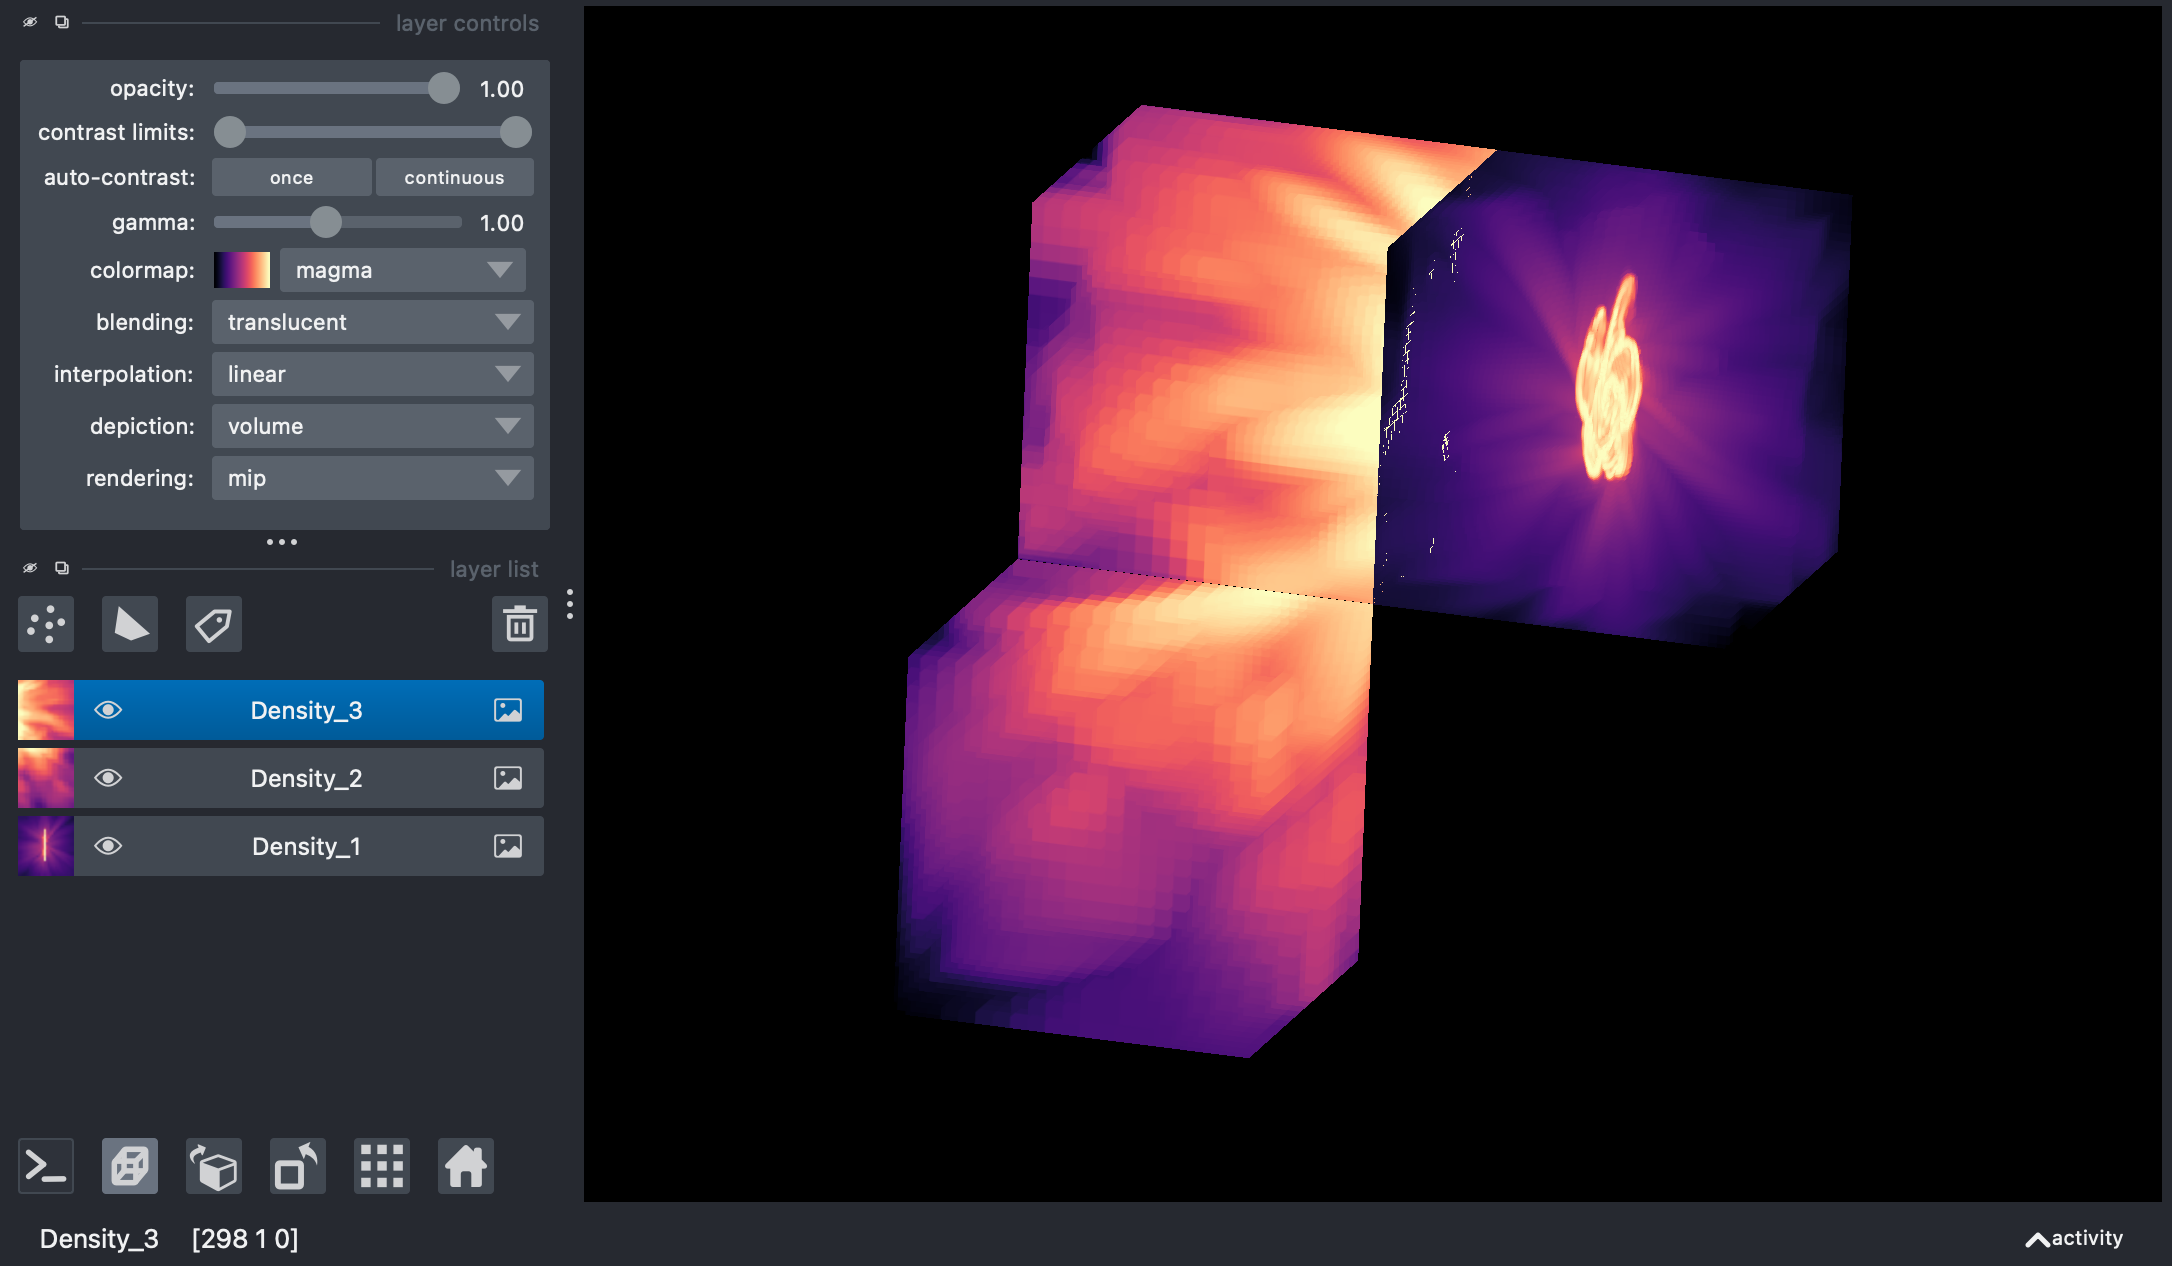

In [7]:
from napari.utils import nbscreenshot
nbscreenshot(viewer)

So we can see that each of these subdomains are scaled to themselves. To scale across layers, we need to set the `contrast_limits` to be the same across the layers. There are several ways to accomplish this. 

### normalizing color limits

The first approach to specifying the color limits across layers is is to use the `normalize_color_limits` method, which will use the data range across the provided list of layers:

In [8]:
yt_scene.normalize_color_limits(["Density_3", "Density_2", "Density_1"], viewer.layers)

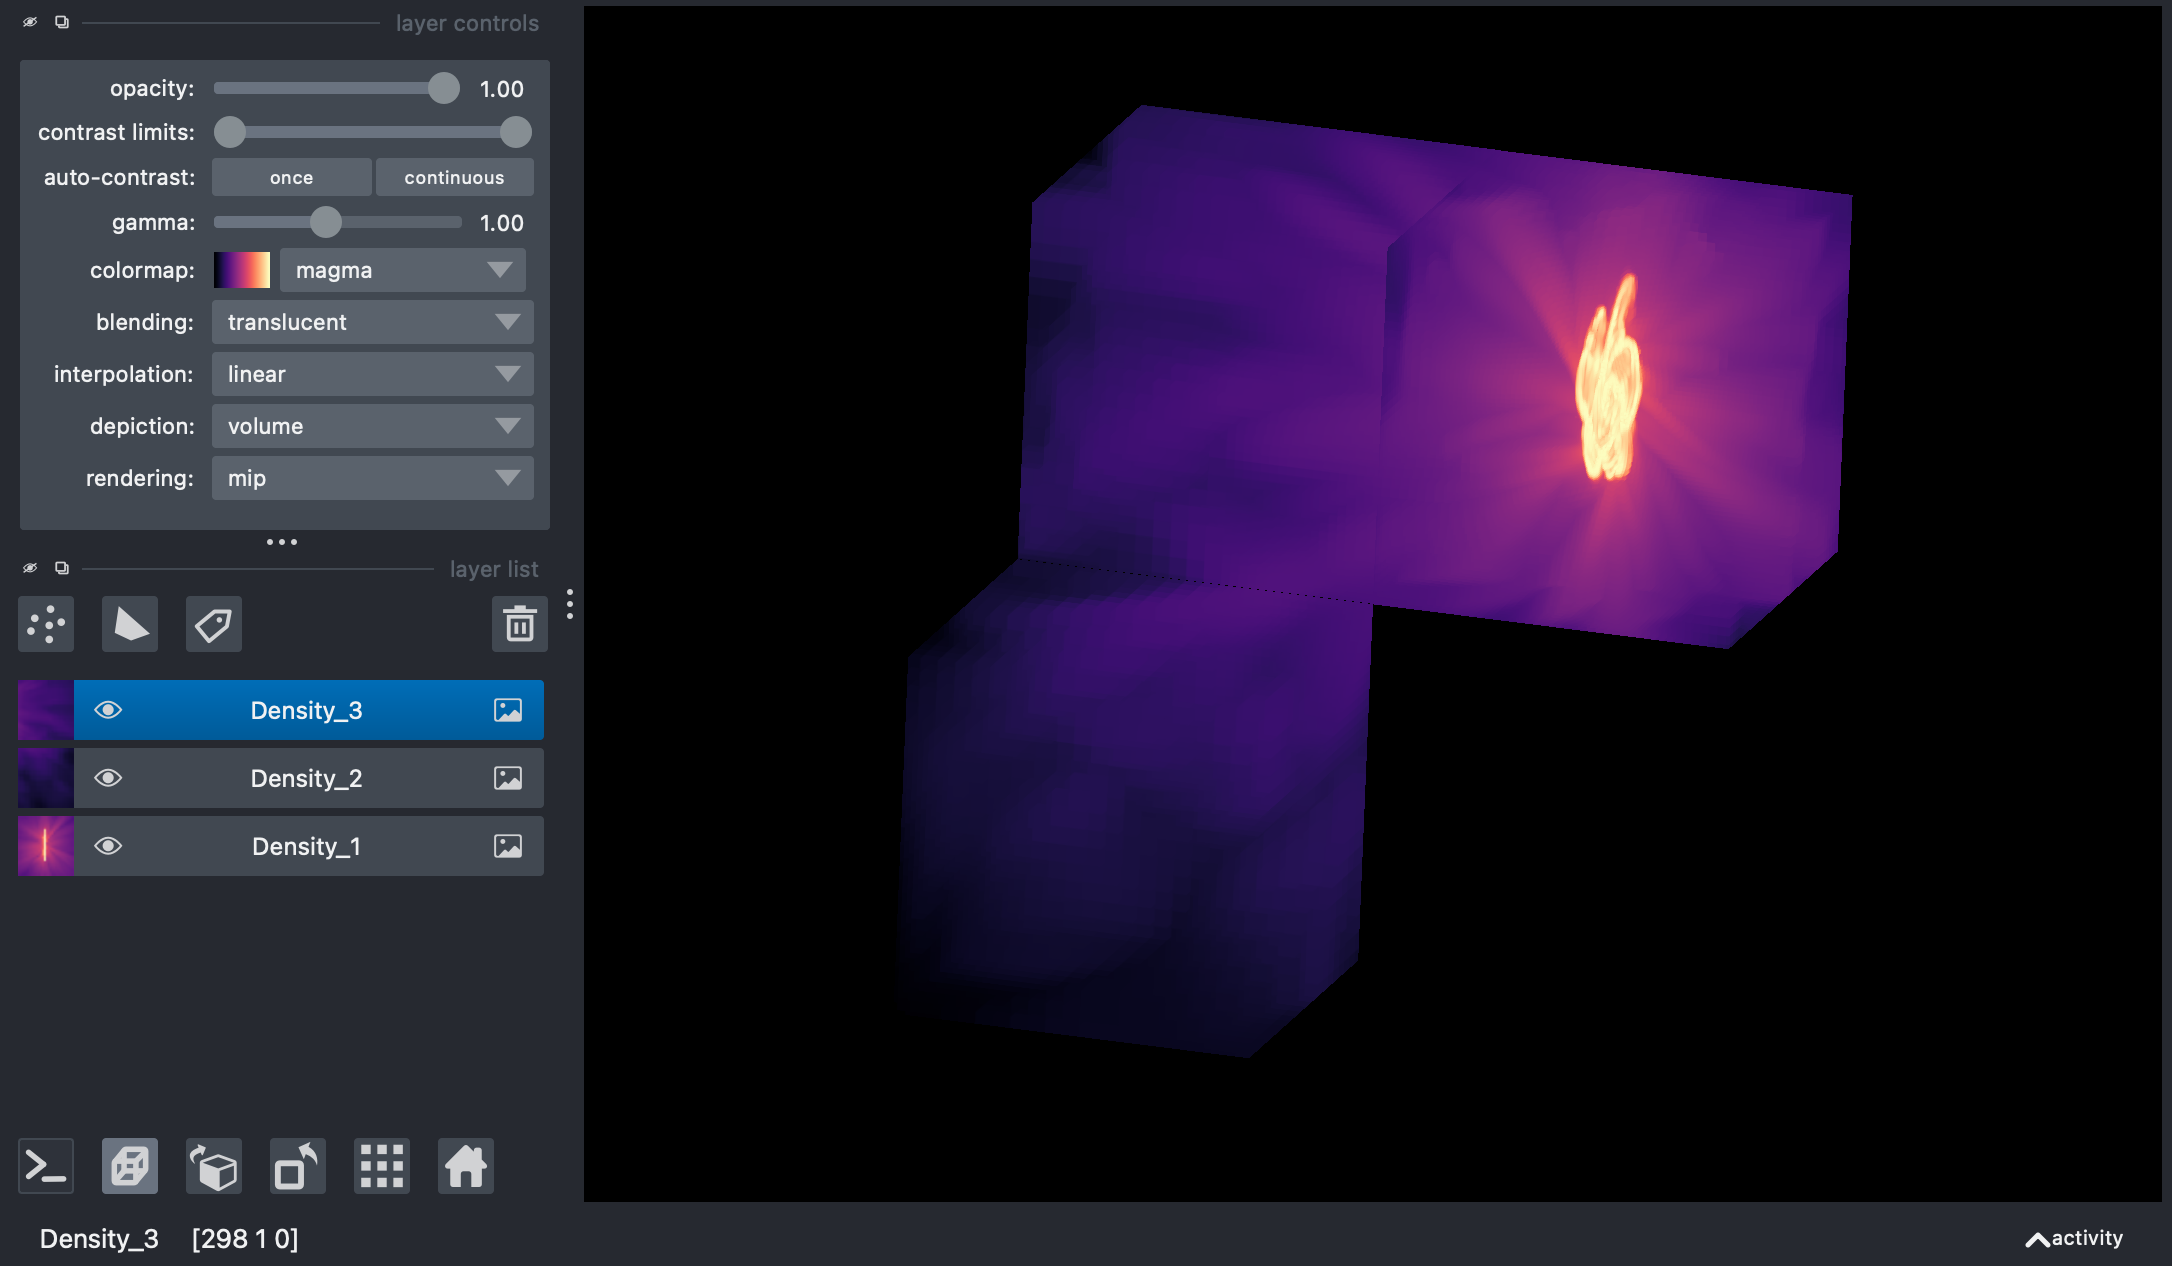

In [9]:
from napari.utils import nbscreenshot
nbscreenshot(viewer)

Internally, this method calls  `get_data_range`, which is a helper function for getting the range of data across layers:

In [10]:
yt_scene.get_data_range(["Density_3", "Density_2", "Density_1"], viewer.layers)

(1.6881177355004957, 6.447333768718712)

### actively linking layers

The other approach is to use napari's ability to link layers. To link layers:

In [11]:
viewer.layers.link_layers(["Density_3", "Density_2", "Density_1"])

and any changes to an attribute of one of these layers is applied to all of them. In the GUI, if you change the `contrast_layer` slider, it will affect all the layers. Or from a notebook, we can do:

In [12]:
viewer.layers["Density_3"].contrast_limits = (2.5, 4)

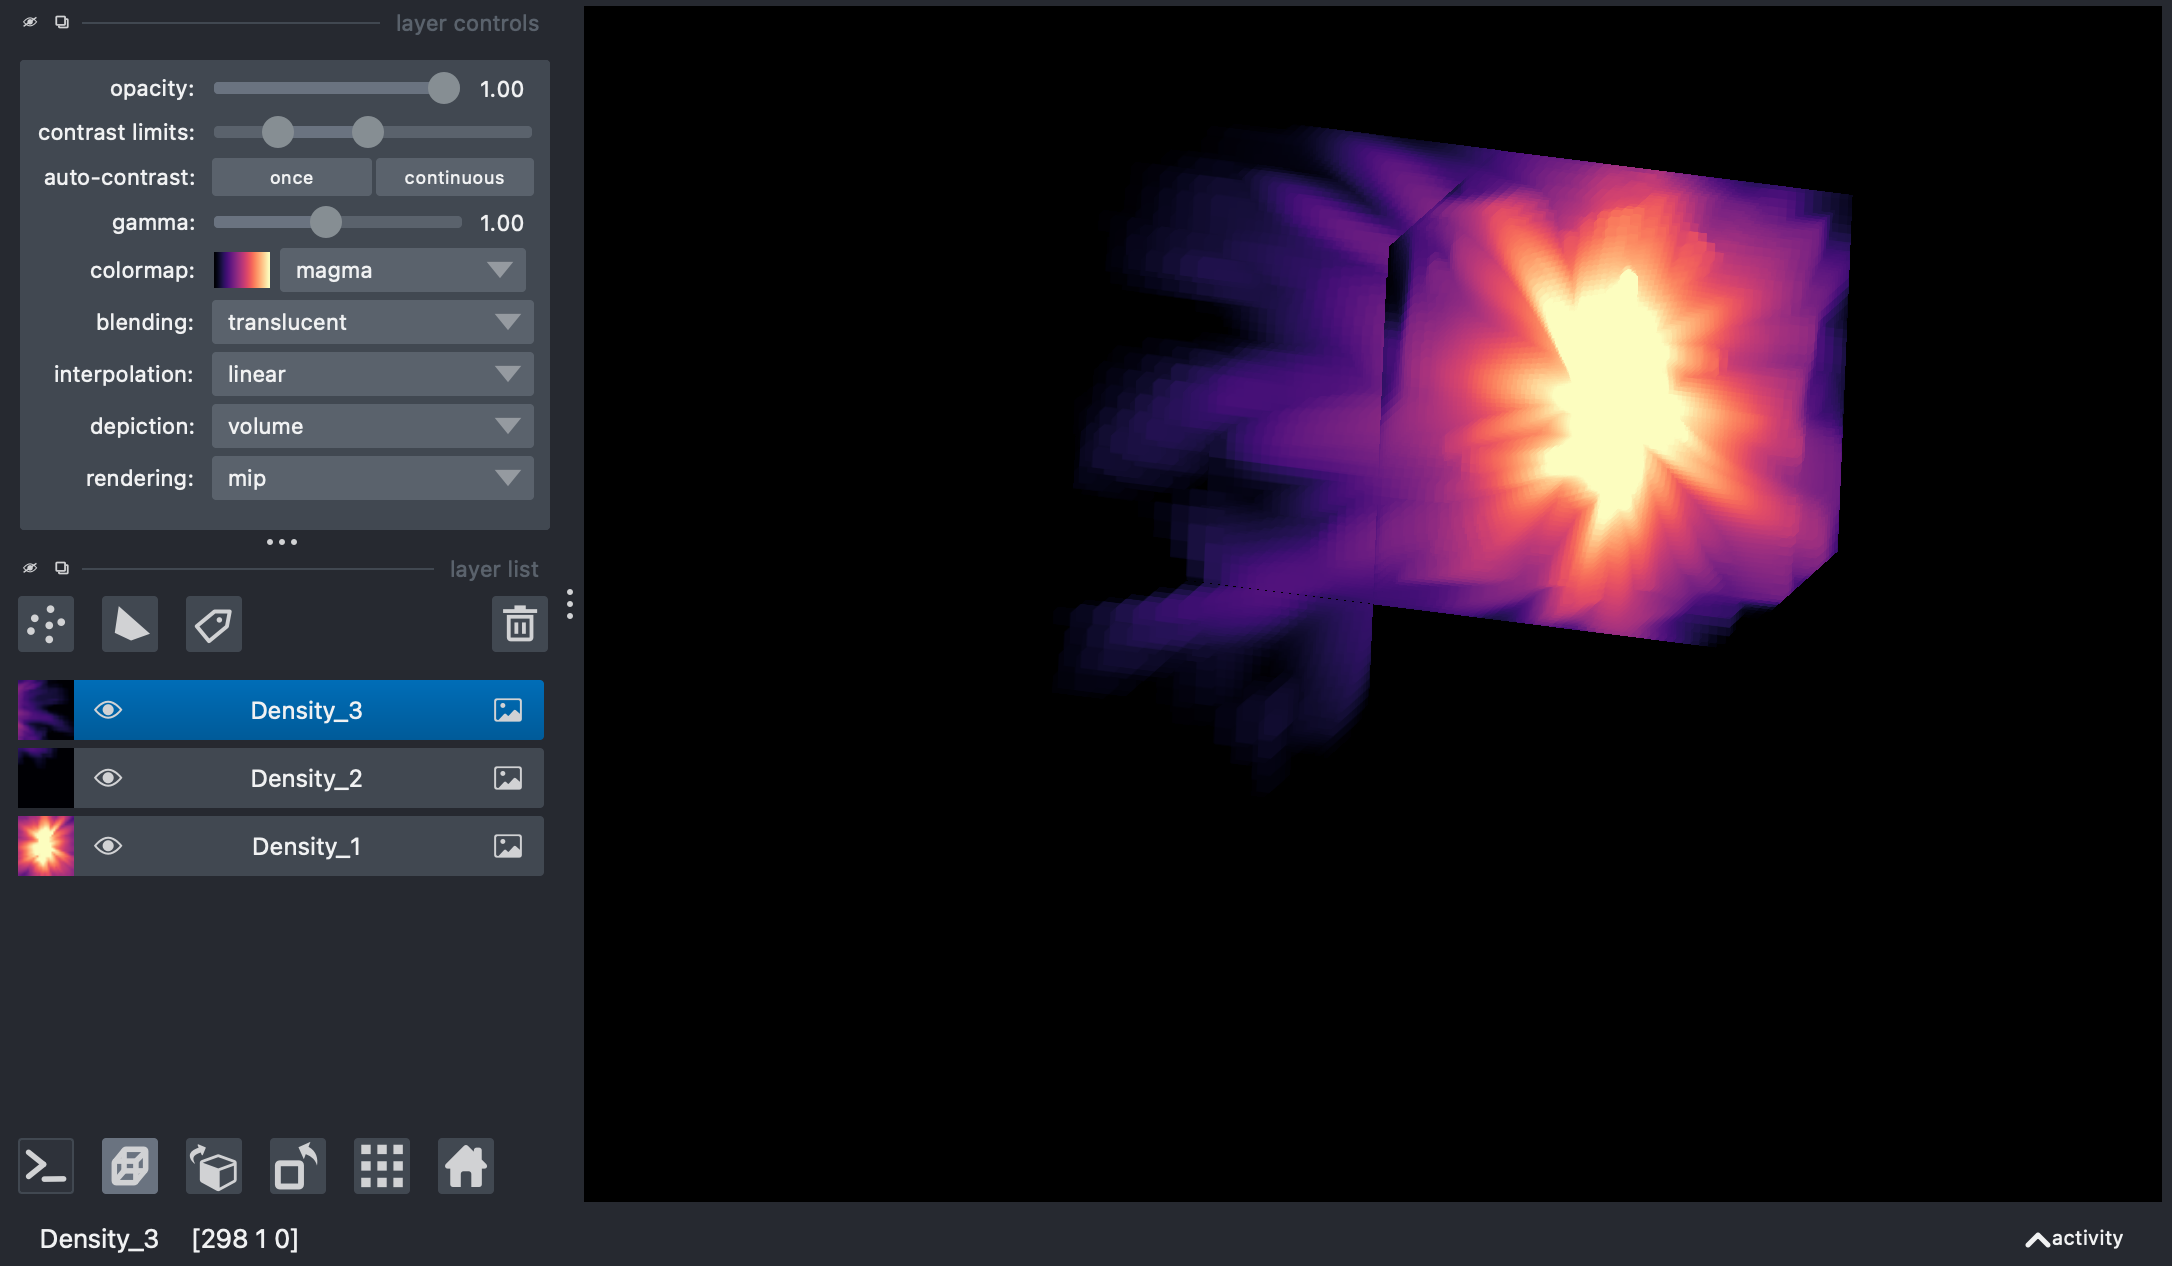

In [13]:
from napari.utils import nbscreenshot
nbscreenshot(viewer)

Note that `add_to_viewer` allows you to specify that you would like to link the new layer to an existing layer as you're adding it. This allows you to skip the step of linking the layers. In the following, we add an initial layer and then link two new layers to that first:

In [14]:
viewer.layers.clear() # first clear existing layers

left_edge = ds.domain_center - ds.arr([10, 10, 10], 'kpc')
right_edge = ds.domain_center + ds.arr([10, 10, 10], 'kpc')
yt_scene.add_region(viewer,
                    ds,
                    ("enzo", "Density"),
                    left_edge = left_edge,
                    right_edge = right_edge,                       
                    resolution=(600, 600, 600),
                    colormap="magma",
                    name="Density_1",
                    blending="translucent")

left_edge = ds.domain_center + ds.arr([10, 10, 10], 'kpc')
right_edge = left_edge + ds.arr([20, 20, 20], 'kpc')
yt_scene.add_region(viewer,
                    ds,
                    ("enzo", "Density"),
                    left_edge = left_edge,
                    right_edge = right_edge,                       
                    resolution=(300, 300, 300),
                    colormap="magma",
                    name="Density_2",
                    link_to="Density_1",
                    blending="translucent")

left_edge = ds.domain_center + ds.arr([-10, -10, 10], 'kpc')
right_edge = left_edge + ds.arr([20, 20, 20], 'kpc')
yt_scene.add_region(viewer,
                    ds,
                    ("enzo", "Density"),
                    left_edge = left_edge,
                    right_edge = right_edge,                       
                    resolution=(300, 300, 300),
                    colormap="magma",
                    name="Density_3",
                    link_to="Density_1",
                    blending="translucent")

and `get_data_range` will by default check linked layers

In [15]:
yt_scene.get_data_range(["Density_1"], viewer.layers)

(1.6881177355004957, 6.447333768718712)

and any modifications to one of the layers will affect all of them. Now to set the `contrast_limits` for all: 

In [16]:
viewer.layers["Density_1"].contrast_limits = (1.7, 5)

or to normalize with the full data range:

In [17]:
yt_scene.normalize_color_limits(["Density_1"], viewer.layers)

to normalize across linked layers.

Note that this works for all layer attributes, not just `contrast_limits`. To change the colormap, for example:

In [18]:
viewer.layers["Density_1"].colormap = 'plasma'

Furthermore, it is also worth noting that you can also provide references to viewer layers directly and omit the `viewer.layers` argument in the above calls:

In [19]:
yt_scene.get_data_range([viewer.layers["Density_1"]])

(1.6881177355004957, 6.447333768718712)